# TO DO
1. Проверить диапазон
2. Проверить на SP500
3. Создать именно пути с резистом и суппортом. 1S - support 1R - resistance
4. Найти pattern в путях? Где задерживалась цена во время пути во время рост или падения? 
   Вектор движения цены для создания кластеров.
5. Если диапазон широкий то какая с большей ли вероятностью что она развернется? количество точек разворота.

- были ли похоже последовательности раньше? 
- если цена сходила на -1, +1, можем ли мы думать, что она пойдет на -4 или около того?
- какой из диапазонов важен (в какой вторник месяца \ года) и как долго он остается важным? 
- остается ли уровень 0.5 (середина диапазона [0;1]) важным через 2 недели? можно ли это предсказать на основнии ширины изначального диапазона или движения цены?
- когда случаются ретесты диапазона [0;1] - через день? 5 дней? две недели?
- некоторые диапазоны дают последовательности +1 - (-3), то есть на одну гармонику вверх, потом на 3 вниз. можно ли это предсказать?
- поэтому мы смотрим на все повтояющиеся последовательности, а потом смотрим на предшействующие этим повтрояющимся события с ценой \ ширину диапазона
- также важно - гармоника - это линия, ограничивающая диапазон сверху \ снизу. то есть гармоника 0 - это низ нашего диапазона, 1 - верх, +2 - это линия ограничивающая один диапазон сверху

## UTC timzone

In [1]:
import requests
import joblib
import pandas as pd
from collections import defaultdict
from datetime import datetime
import pytz

# Create a datetime object in 'US/Eastern' timezone
eastern_timezone = pytz.timezone('US/Eastern')
eastern_datetime = eastern_timezone.localize(datetime(2022, 1, 1, 12, 0, 0))

# Convert to UTC
utc_datetime = eastern_datetime.astimezone(pytz.UTC)

print("Original datetime (US/Eastern):", eastern_datetime)
print("Converted datetime (UTC):", utc_datetime)

Original datetime (US/Eastern): 2022-01-01 12:00:00-05:00
Converted datetime (UTC): 2022-01-01 17:00:00+00:00


# Load Data

In [2]:
es_df = pd.read_csv('data/CME_MINI_DL_ES1!, 60 (1).csv')
es_df['time'] = pd.to_datetime(es_df['time'])
es_df = es_df.set_index('time')
es_df

,open,high,low,close
time,,,,
2020-01-09 13:00:00+00:00,3268.50,3271.75,3267.25,3270.75
2020-01-09 14:00:00+00:00,3270.75,3274.00,3265.50,3269.25
2020-01-09 15:00:00+00:00,3269.00,3274.75,3266.00,3274.00
2020-01-09 16:00:00+00:00,3274.00,3275.25,3270.00,3274.25
2020-01-09 17:00:00+00:00,3274.50,3275.25,3264.25,3269.50
...,...,...,...,...
2024-01-12 17:00:00+00:00,4807.00,4815.00,4803.50,4811.50
2024-01-12 18:00:00+00:00,4811.50,4820.50,4811.50,4819.50
2024-01-12 19:00:00+00:00,4819.75,4823.75,4811.50,4812.75


In [3]:
start_tuesday_cond = (
    ((es_df.index.weekday >= 1) & (es_df.index.hour >= 5))
    & ((es_df.index.weekday <= 2) & (es_df.index.hour <= 13))
)
es_df['is_diapazon_day'] = start_tuesday_cond
es_df['calendar_week'] = es_df.index.year.astype(str) + '-' + es_df.index.week.astype(str)

es_df['diapazan_week'] = es_df.loc[es_df['is_diapazon_day'], 'calendar_week']
es_df['diapazan_week'] = es_df['diapazan_week'].fillna(method='ffill')
es_df['diapazan_week'].count() - es_df['diapazan_week'].shape[0]

/tmp/ipykernel_6636/699407021.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  es_df['calendar_week'] = es_df.index.year.astype(str) + '-' + es_df.index.week.astype(str)


-61

In [13]:
window_size = (24 - 5) + 13
window_high = es_df[start_tuesday_cond].groupby('diapazan_week')['high'].max()
window_low = es_df[start_tuesday_cond].groupby('diapazan_week')['low'].min()
window_mid = (window_high + window_low) / 2
diapazon_ser = window_high - window_low
diapazon_ser

diapazan_week
2020-10     71.50
2020-11    114.75
2020-12    154.75
2020-13    219.75
2020-14    168.50
            ...  
2023-7      70.50
2023-8      77.50
2023-9      40.25
2024-1      62.50
2024-2      30.50
Length: 209, dtype: float64

In [14]:
es_df[(es_df['diapazan_week'] == '2021-1') & (es_df['is_diapazon_day'])]

,open,high,low,close,is_diapazon_day,calendar_week,diapazan_week
time,,,,,,,
2021-01-05 05:00:00+00:00,3690.75,3695.75,3688.50,3693.75,True,2021-1,2021-1
2021-01-05 06:00:00+00:00,3693.75,3701.00,3692.75,3700.25,True,2021-1,2021-1
2021-01-05 07:00:00+00:00,3700.50,3701.00,3677.75,3679.50,True,2021-1,2021-1
2021-01-05 08:00:00+00:00,3679.25,3703.50,3679.25,3696.75,True,2021-1,2021-1
2021-01-05 09:00:00+00:00,3696.50,3703.00,3693.75,3698.25,True,2021-1,2021-1
2021-01-05 10:00:00+00:00,3698.25,3701.75,3696.75,3698.25,True,2021-1,2021-1
2021-01-05 11:00:00+00:00,3698.50,3704.00,3691.25,3694.00,True,2021-1,2021-1
2021-01-05 12:00:00+00:00,3693.75,3695.50,3681.00,3689.75,True,2021-1,2021-1
2021-01-05 13:00:00+00:00,3689.50,3692.00,3674.00,3674.50,True,2021-1,2021-1


In [15]:
print('High:', window_high['2021-1'], 'Low:', window_low['2021-1'])

High: 3719.25 Low: 3674.0


In [116]:
es_df['mid_diapazon'] = es_df['diapazan_week'].map(window_mid)
mid_diapazon_table = pd.pivot_table(
    es_df, index=es_df.index, columns=['diapazan_week'], 
    values='mid_diapazon', aggfunc='last'
)
mid_diapazon_table = mid_diapazon_table.fillna(method='ffill', axis=0)
mid_diapazon_table

diapazan_week,2020-10,2020-11,2020-12,2020-13,2020-14,2020-15,2020-16,2020-17,2020-18,2020-19,...,2023-5,2023-50,2023-51,2023-52,2023-6,2023-7,2023-8,2023-9,2024-1,2024-2
time,,,,,,,,,,,,,,,,,,,,,
2020-01-14 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12 17:00:00+00:00,3064.25,2821.625,2420.625,2388.125,2551.5,2688.625,2794.5,2769.625,2891.625,2859.375,...,4046.375,4690.875,4808.125,4817.875,4146.125,4151.25,4034.25,3983.625,4796.75,4788.75
2024-01-12 18:00:00+00:00,3064.25,2821.625,2420.625,2388.125,2551.5,2688.625,2794.5,2769.625,2891.625,2859.375,...,4046.375,4690.875,4808.125,4817.875,4146.125,4151.25,4034.25,3983.625,4796.75,4788.75
2024-01-12 19:00:00+00:00,3064.25,2821.625,2420.625,2388.125,2551.5,2688.625,2794.5,2769.625,2891.625,2859.375,...,4046.375,4690.875,4808.125,4817.875,4146.125,4151.25,4034.25,3983.625,4796.75,4788.75


In [117]:
es_df['high_diapazon'] = es_df['diapazan_week'].map(window_high)
high_diapazon_table = pd.pivot_table(
    es_df, index=es_df.index, columns=['diapazan_week'], 
    values='high_diapazon', aggfunc='last'
)
high_diapazon_table = high_diapazon_table.fillna(method='ffill', axis=0)
es_df['low_diapazon'] = es_df['diapazan_week'].map(window_low)
low_diapazon_table = pd.pivot_table(
    es_df, index=es_df.index, columns=['diapazan_week'], 
    values='low_diapazon', aggfunc='last'
)
low_diapazon_table = low_diapazon_table.fillna(method='ffill', axis=0)
low_diapazon_table

diapazan_week,2020-10,2020-11,2020-12,2020-13,2020-14,2020-15,2020-16,2020-17,2020-18,2020-19,...,2023-5,2023-50,2023-51,2023-52,2023-6,2023-7,2023-8,2023-9,2024-1,2024-2
time,,,,,,,,,,,,,,,,,,,,,
2020-01-14 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12 17:00:00+00:00,3028.5,2764.25,2343.25,2278.25,2467.25,2627.25,2754.5,2731.5,2856.5,2832.5,...,4007.5,4672.5,4792.0,4806.5,4113.0,4116.0,3995.5,3963.5,4765.5,4773.5
2024-01-12 18:00:00+00:00,3028.5,2764.25,2343.25,2278.25,2467.25,2627.25,2754.5,2731.5,2856.5,2832.5,...,4007.5,4672.5,4792.0,4806.5,4113.0,4116.0,3995.5,3963.5,4765.5,4773.5
2024-01-12 19:00:00+00:00,3028.5,2764.25,2343.25,2278.25,2467.25,2627.25,2754.5,2731.5,2856.5,2832.5,...,4007.5,4672.5,4792.0,4806.5,4113.0,4116.0,3995.5,3963.5,4765.5,4773.5


<Axes: title={'center': 'ES'}, xlabel='time'>

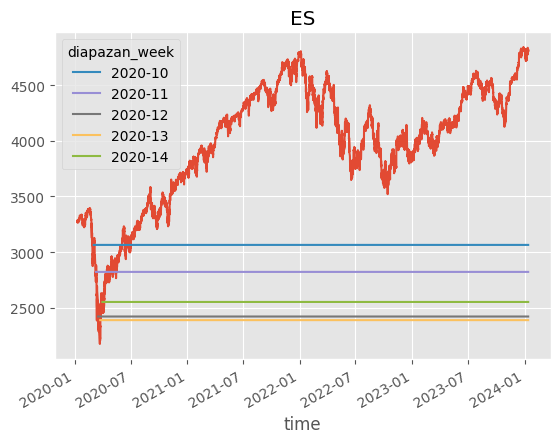

In [118]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
ax = es_df['close'].plot()
mid_diapazon_table.iloc[:, :5].plot(ax=ax, title='ES')

In [119]:
harmonics = pd.DataFrame(index=mid_diapazon_table.columns, columns=list(range(-6, 7)))
n_harmonics = harmonics.shape[1]
for week in mid_diapazon_table.columns:
    for harmonic in harmonics.columns:
        harmonics.loc[week, harmonic] = -harmonic * diapazon[week] + window_high[week]
harmonics = harmonics.astype(float)
harmonics

,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6
diapazan_week,,,,,,,,,,,,,
2020-10,3529.00,3457.50,3386.00,3314.50,3243.00,3171.50,3100.00,3028.50,2957.00,2885.50,2814.00,2742.50,2671.00
2020-11,3567.50,3452.75,3338.00,3223.25,3108.50,2993.75,2879.00,2764.25,2649.50,2534.75,2420.00,2305.25,2190.50
2020-12,3426.50,3271.75,3117.00,2962.25,2807.50,2652.75,2498.00,2343.25,2188.50,2033.75,1879.00,1724.25,1569.50
2020-13,3816.50,3596.75,3377.00,3157.25,2937.50,2717.75,2498.00,2278.25,2058.50,1838.75,1619.00,1399.25,1179.50
2020-14,3646.75,3478.25,3309.75,3141.25,2972.75,2804.25,2635.75,2467.25,2298.75,2130.25,1961.75,1793.25,1624.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-7,4609.50,4539.00,4468.50,4398.00,4327.50,4257.00,4186.50,4116.00,4045.50,3975.00,3904.50,3834.00,3763.50
2023-8,4538.00,4460.50,4383.00,4305.50,4228.00,4150.50,4073.00,3995.50,3918.00,3840.50,3763.00,3685.50,3608.00
2023-9,4245.25,4205.00,4164.75,4124.50,4084.25,4044.00,4003.75,3963.50,3923.25,3883.00,3842.75,3802.50,3762.25


In [120]:
harmonics.iloc[0]

-6    3529.0
-5    3457.5
-4    3386.0
-3    3314.5
-2    3243.0
-1    3171.5
 0    3100.0
 1    3028.5
 2    2957.0
 3    2885.5
 4    2814.0
 5    2742.5
 6    2671.0
Name: 2020-10, dtype: float64

In [121]:
es_df = es_df.dropna()
es_df

,open,high,low,close,is_diapazon_day,calendar_week,diapazan_week,mid_diapazon,high_diapazon,low_diapazon
time,,,,,,,,,,
2020-01-14 05:00:00+00:00,3289.25,3290.75,3287.50,3288.25,True,2020-3,2020-3,3283.875,3292.5,3275.25
2020-01-14 06:00:00+00:00,3288.25,3290.25,3287.75,3289.75,True,2020-3,2020-3,3283.875,3292.5,3275.25
2020-01-14 07:00:00+00:00,3289.75,3290.50,3285.25,3285.50,True,2020-3,2020-3,3283.875,3292.5,3275.25
2020-01-14 08:00:00+00:00,3285.50,3286.00,3275.25,3283.00,True,2020-3,2020-3,3283.875,3292.5,3275.25
2020-01-14 09:00:00+00:00,3283.00,3292.50,3282.00,3291.00,True,2020-3,2020-3,3283.875,3292.5,3275.25
...,...,...,...,...,...,...,...,...,...,...
2024-01-12 17:00:00+00:00,4807.00,4815.00,4803.50,4811.50,False,2024-2,2024-2,4788.750,4804.0,4773.50
2024-01-12 18:00:00+00:00,4811.50,4820.50,4811.50,4819.50,False,2024-2,2024-2,4788.750,4804.0,4773.50
2024-01-12 19:00:00+00:00,4819.75,4823.75,4811.50,4812.75,False,2024-2,2024-2,4788.750,4804.0,4773.50


# Add week number

In [122]:
week_number_within_month = (
    (es_df.index.tz_localize(None) - pd.to_datetime(es_df.index.to_period("M").start_time)).days // 7) + 1

es_df['calendar_week_number_within_month'] = week_number_within_month
es_df['calendar_week_number_within_month'].value_counts()

/home/duwlat/.pyenv/versions/3.8.10/envs/cpu-pytorch-env/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/tmp/ipykernel_5176/1261846340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_df['calendar_week_number_within_month'] = week_number_within_month


2    5515
3    5459
1    5401
4    5393
5    1895
Name: calendar_week_number_within_month, dtype: int64

In [123]:
# BECAUSE first element in list usually is first met by algorithm
diapazan_week2week_month = (
    es_df.groupby(['diapazan_week'])['calendar_week_number_within_month'].unique().str[0]
)
es_df['diapazan_week_number_within_month'] = es_df['diapazan_week'].map(diapazan_week2week_month)
es_df['diapazan_week_number_within_month']

/tmp/ipykernel_5176/3675042651.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es_df['diapazan_week_number_within_month'] = es_df['diapazan_week'].map(diapazan_week2week_month)


time
2020-01-14 05:00:00+00:00    2
2020-01-14 06:00:00+00:00    2
2020-01-14 07:00:00+00:00    2
2020-01-14 08:00:00+00:00    2
2020-01-14 09:00:00+00:00    2
                            ..
2024-01-12 17:00:00+00:00    2
2024-01-12 18:00:00+00:00    2
2024-01-12 19:00:00+00:00    2
2024-01-12 20:00:00+00:00    2
2024-01-12 21:00:00+00:00    2
Name: diapazan_week_number_within_month, Length: 23663, dtype: int64

In [124]:
diapazan_week2weeknumber = es_df.drop_duplicates(subset=[
    'diapazan_week', 'diapazan_week_number_within_month'
]).set_index('diapazan_week')['diapazan_week_number_within_month']
diapazan_week2weeknumber.dropna().shape, len(diapazan_week2weeknumber.to_dict())

((209,), 209)

# Examine Future picrs


In [125]:
def get_harmonics_range(search_price: float, 
                        previous_price: float, 
                        diapozan_week: 'str', 
                        margin_of_error: float = 0.02):
    
    sorted_series = harmonics.loc[diapozan_week].sort_values().copy()
    if previous_price >= search_price:
        sorted_series = sorted_series * (1 + margin_of_error)
    else:
        sorted_series = sorted_series * (1 - margin_of_error)
    index = sorted_series.searchsorted(search_price)
    
    # Get the minimum and maximum thresholds
    min_threshold = index-1
    max_threshold = index
    harmonics_range = sorted_series.iloc[min_threshold: max_threshold+1].index
    if not harmonics_range.empty:
        
        return harmonics_range[0] - 1
    return harmonics.columns.max()

In [126]:
def remove_duplicates(input_string):
    cleaned_path = []
    last_char = None

    for char in input_string:
        if char != last_char:
            cleaned_path.append(char)
            last_char = char

    return ''.join(cleaned_path)

# Example
input_str = '1233333111'
output_str = remove_duplicates(input_str)
output_str

'1231'

In [127]:
week_number2diapazonweek = defaultdict(list)
search_df = es_df[['diapazan_week_number_within_month', 'diapazan_week']].drop_duplicates()
week_numbers = es_df['diapazan_week_number_within_month'].unique().tolist()

for week_number in week_numbers:
    weeks = (
        search_df.loc[search_df['diapazan_week_number_within_month'] == week_number, 'diapazan_week']
    )
    week_number2diapazonweek[week_number] = weeks.values.tolist()
len(week_number2diapazonweek)

5

In [25]:
def get_week2paths(window: int, granularity: str, past_shift: int):
    """
        In: window - int - number of weeks forward to look forward
            granularity - str - at which frequency to look forward. e.g. 1d, 1w, 1h.
            past_shift - int - on how many "granularity" to shift prices from the past
                               to get direction of prices
        Out: at which diapazon look
    """
    
    week2path2count  = {week_number: {} for week_number in week_numbers}
    diapazons_week = harmonics.index

    for week_number, diapazons_weeks in week_number2diapazonweek.items():
        for diapozon_week in diapazons_weeks:
            path = ''
            harmonic_levels = harmonics.loc[diapozon_week]

            start_date = es_df[
                (es_df['diapazan_week'] == diapozon_week) & (~es_df['is_diapazon_day'])
            ].index.min()
            end_date = start_date + pd.Timedelta(window, unit='w')

            future_prices = es_df.loc[start_date: end_date].resample(granularity)['close'].last()
            past_prices = future_prices.shift(past_shift)
            for past_price, curr_price in zip(past_prices, future_prices):
                if past_price is None:
                    continue
                
                harmonic_number = get_harmonics_range(curr_price, past_price, diapozon_week)
                path += f'{harmonic_number}+'

            path = path.split('+')
            week2path2count[week_number][diapozon_week] = path
    return week2path2count

In [26]:
%%time
week2path2count = get_week2paths(4, granularity='1h', past_shift=3)
len(week2path2count)

CPU times: user 26.6 s, sys: 122 ms, total: 26.7 s
Wall time: 26.7 s


5

In [27]:
path2count = pd.Series(week2path2count[2])
path2count.head()

2020-3     [-4, -4, -4, -4, -4, 4, 4, -4, -7, 4, 4, -4, -...
2020-7     [-4, -4, -4, -4, 4, 4, 4, 4, -7, -4, 4, -4, 4,...
2020-11    [0, 0, 0, 1, 0, -1, -1, -7, 0, 0, 0, 1, 1, 1, ...
2020-16    [-1, -1, -1, -1, -1, -1, -1, -7, -1, 0, -1, 0,...
2020-20    [-1, -1, -1, 0, 0, 1, 1, -7, 1, 1, 0, 1, 0, 0,...
dtype: object

In [28]:
import numpy as np 
pathes_df = (
    path2count.apply(pd.Series)
        .replace('', np.nan)
        .dropna(how='all', axis=1)
        .astype(float)
        .dropna(axis=0)
)
pathes_df.head()

,0,1,2,3,4,5,6,7,8,9,...,663,664,665,666,667,668,669,670,671,672
2020-3,-4.0,-4.0,-4.0,-4.0,-4.0,4.0,4.0,-4.0,-7.0,4.0,...,-7.0,-7.0,-1.0,-1.0,-1.0,-7.0,-1.0,-7.0,-7.0,-7.0
2020-7,-4.0,-4.0,-4.0,-4.0,4.0,4.0,4.0,4.0,-7.0,-4.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
2020-11,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-7.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
2020-16,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-7.0,-1.0,0.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-1.0,-1.0
2020-20,-1.0,-1.0,-1.0,0.0,0.0,1.0,1.0,-7.0,1.0,1.0,...,-4.0,-3.0,-2.0,-2.0,-2.0,-2.0,-4.0,-4.0,-2.0,-4.0


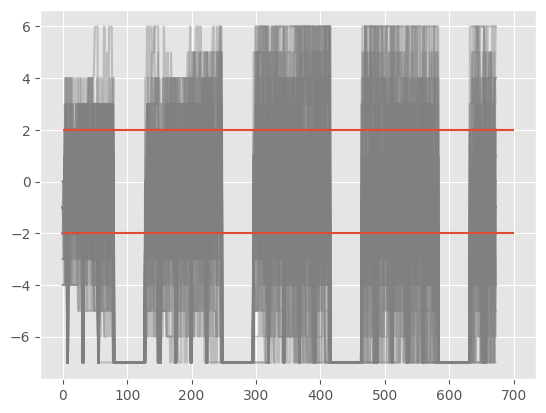

In [29]:
for idx in range(pathes_df.shape[0]):
    pathes_df.T.iloc[:, idx].plot(alpha=0.4, color='grey')
plt.hlines(2, 0, 700)
plt.hlines(-2, 0, 700)

In [30]:
harmonic2freq = {}
for harmonic in range(0, 7):
    is_in_middles = (pathes_df <= harmonic) & (pathes_df >= -harmonic)
    freq = is_in_middles.sum().sum() / pathes_df.count().sum()
    harmonic2freq[harmonic] = freq
harmonic2freq = pd.Series(harmonic2freq)
harmonic2freq

0    0.090360
1    0.263590
2    0.434312
3    0.534423
4    0.595251
5    0.625279
6    0.659702
dtype: float64

# Percentage in each harmonic for each week

In [31]:
def get_total_weeks_pathes(week2path2count):
    total_pathes_df = pd.DataFrame()
    for week, path2count_dict in week2path2count.items():
        path2count_week = pd.Series(path2count_dict)
        pathes_df_week = (
            path2count_week.apply(pd.Series)
                .replace('', np.nan)
                .dropna(how='all', axis=1)
                .astype(float)
                .dropna(axis=0)
        )
        total_pathes_df = pd.concat([pathes_df_week, total_pathes_df], axis=0)
    total_pathes_df = total_pathes_df.sort_index()
#     total_pathes_df = total_pathes_df.reset_index(drop=True)
    return total_pathes_df
total_pathes_df = get_total_weeks_pathes(week2path2count)
print(total_pathes_df.shape)
display(total_pathes_df)

(205, 673)


,0,1,2,3,4,5,6,7,8,9,...,663,664,665,666,667,668,669,670,671,672
2020-10,-1.0,-1.0,-1.0,1.0,2.0,2.0,2.0,2.0,-7.0,2.0,...,6.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0
2020-11,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-7.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
2020-12,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-7.0,0.0,0.0,...,-3.0,-3.0,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0
2020-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.0,-1.0,0.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-1.0,-1.0,-2.0,-1.0
2020-14,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-7.0,0.0,0.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-50,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0,-7.0,-3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-6,-1.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-2.0,-7.0,1.0,...,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,3.0
2023-7,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-7.0,1.0,...,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2023-8,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-7.0,-1.0,...,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


In [32]:
week_number_pathes_df = total_pathes_df.index.map(diapazan_week2weeknumber)

week_number2frac = pd.DataFrame()
for week, group in total_pathes_df.groupby(week_number_pathes_df):
    fracs = pd.DataFrame()
    for idx, row in group.iterrows():
        perc_counts = row.value_counts(normalize=False)
        fracs = pd.concat([perc_counts.to_frame(), fracs], axis=1).fillna(0)
    fracs = fracs.sum(axis=1)
    fracs.name = week
    
    week_number2frac = pd.concat([week_number2frac, fracs], axis=1)
week_number2frac

,1,2,3,4,5
-7.0,11333.0,10993.0,10769.0,11342.0,4247.0
-6.0,493.0,425.0,426.0,447.0,152.0
-5.0,556.0,566.0,651.0,975.0,252.0
-4.0,1080.0,1124.0,1277.0,1599.0,297.0
-3.0,1995.0,1916.0,1733.0,2160.0,611.0
-2.0,2665.0,3300.0,2992.0,2856.0,1022.0
-1.0,2857.0,2693.0,3330.0,2983.0,1093.0
0.0,2812.0,2919.0,2758.0,2930.0,847.0
1.0,2672.0,2903.0,2306.0,2377.0,734.0
2.0,2073.0,2215.0,2035.0,1569.0,505.0


In [33]:
def make_pretty(styler, vmin, vmax):
    styler.format("{:.3f}")
    styler.background_gradient(axis=None, vmin=vmin, vmax=vmax, cmap="YlGnBu")
    return styler
week_number2frac = week_number2frac / week_number2frac.sum(axis=0).values[None, :]
week_number2frac.style.pipe(make_pretty, 0, .3)

,1,2,3,4,5
-7.0,0.358,0.340,0.340,0.359,0.394
-6.0,0.016,0.013,0.013,0.014,0.014
-5.0,0.018,0.018,0.021,0.031,0.023
-4.0,0.034,0.035,0.040,0.051,0.028
-3.0,0.063,0.059,0.055,0.068,0.057
-2.0,0.084,0.102,0.095,0.090,0.095
-1.0,0.090,0.083,0.105,0.094,0.102
0.0,0.089,0.090,0.087,0.093,0.079
1.0,0.084,0.090,0.073,0.075,0.068
2.0,0.066,0.069,0.064,0.050,0.047


In [34]:
from sklearn.preprocessing import StandardScaler, Normalizer
scaler = StandardScaler()
z_scores_frac = scaler.fit_transform(week_number2frac)
z_scores_frac = pd.DataFrame(z_scores_frac, index=week_number2frac.index, columns=week_number2frac.columns)
z_scores_frac.style.pipe(make_pretty, -2, 2)

,1,2,3,4,5
-7.0,3.397,3.337,3.353,3.384,3.439
-6.0,-0.661,-0.723,-0.722,-0.675,-0.610
-5.0,-0.638,-0.669,-0.634,-0.478,-0.511
-4.0,-0.441,-0.455,-0.387,-0.246,-0.467
-3.0,-0.099,-0.150,-0.207,-0.037,-0.156
-2.0,0.152,0.381,0.289,0.222,0.250
-1.0,0.224,0.148,0.422,0.270,0.320
0.0,0.207,0.235,0.196,0.250,0.077
1.0,0.154,0.229,0.018,0.044,-0.035
2.0,-0.070,-0.036,-0.088,-0.257,-0.261


In [35]:
diffs = week_number2frac - week_number2frac.mean(axis=1).values[:, None]
diffs.style.pipe(make_pretty, -0.05, 0.05)

,1,2,3,4,5
-7.0,-0.000,-0.018,-0.018,0.000,0.036
-6.0,0.001,-0.001,-0.001,0.000,0.000
-5.0,-0.004,-0.004,-0.001,0.009,0.001
-4.0,-0.003,-0.003,0.003,0.013,-0.010
-3.0,0.003,-0.001,-0.006,0.008,-0.004
-2.0,-0.009,0.009,0.001,-0.003,0.002
-1.0,-0.005,-0.012,0.010,-0.001,0.007
0.0,0.001,0.003,-0.000,0.005,-0.009
1.0,0.006,0.012,-0.005,-0.003,-0.010
2.0,0.007,0.010,0.005,-0.009,-0.012


## 80% of all movement happens inside -2:+2 harmonics range

# Find Probability of getting maxes

In [36]:
min_start = -2
max_end = -6
gap_days_index = 3

row_increasing_patterns = []
for idx, row in pathes_df.iterrows():
    
    # FILTER OUT ROWS WITHOUT NEEDED VALUES
    if min_start < max_end:

        row = row[(row >= min_start) & (row <= max_end)]
    else:
        row = row[(row <= min_start) & (row >= max_end)]
    
    
    if (not row.empty) and (max_end in row.values):
        
        # DISJOIN ROWS BY TIME
        index = pd.Series(row.index)
        start_indices = index[index > (index.shift(1) + gap_days_index)].values
        index_of_start_indices = index[index > (index.shift(1) + gap_days_index)].index.values

        for idx, start_index in enumerate(start_indices):
            if idx == len(start_indices) -1:
                part_row = row[index_of_start_indices[idx]:]
            else:
                part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]]
            
            # FILTER OUT ONLY INCREASING PATERNS
            if max_end in part_row.values:
                break
                prev_harmonic = None
                start_index = 0
                part_row = part_row.values
                min_harmonic = part_row[0]

                for idx, harmonic_level in enumerate(part_row):
                    if harmonic_level == max_end and prev_harmonic != max_end:
                        increasing_harmonic = row_increasing[start_index: idx+1]
                        if len(increasing_harmonic) > 1 and part_row[start_index] != harmonic_level:
                            row_increasing_patterns.append(increasing_harmonic)
                        start_index = idx+1
                        min_harmonic = part_row[start_index]

                    if harmonic_level < min_harmonic:
                        min_harmonic = harmonic_level
                        start_index = idx + 1
                    prev_harmonic = harmonic_level
            
part_row = part_row.values
row_increasing_patterns = pd.DataFrame(row_increasing_patterns)
row_increasing_patterns

""


In [37]:
prev_harmonic = None
increasing_harmonics = []
start_index = 0
display(part_row)
min_harmonic = part_row[0]
for idx, harmonic_level in enumerate(part_row):
    if harmonic_level == max_end and prev_harmonic != max_end:
        increasing_harmonic = part_row[start_index: idx+1]
        print(increasing_harmonic)
        if len(increasing_harmonic) > 1 and part_row[start_index] == min_start:
            increasing_harmonics.append(increasing_harmonic)
        start_index = idx+1
        if start_index < len(part_row)-1:
            min_harmonic = part_row[start_index]
    
    # find the smallest harmonic start
    if min_start < max_end:
        if harmonic_level < min_harmonic:
            min_harmonic = harmonic_level
            start_index = idx + 1
    else:
        if harmonic_level > min_harmonic:
            min_harmonic = harmonic_level
            start_index = idx + 1
    prev_harmonic = harmonic_level
    
for row_plot in increasing_harmonics:
    pd.Series(row_plot).plot()

array([-5., -5., -5., -5., -5., -6., -6., -6.])

[-5. -5. -5. -5. -5. -6.]


In [38]:
all_higher_than_treshold_patterns = []
for idx, row in pathes_df.iterrows():
    if min_start < max_end:
        row = row[(row >= min_start)]#.tolist()
    else:
        row = row[(row <= min_start)]#.tolist()

    if not row.empty:
        index = pd.Series(row.index)
        start_indices = index[index > (index.shift(1) + gap_days_index)].values
        index_of_start_indices = index[index > (index.shift(1) + gap_days_index)].index.values

        for idx, start_index in enumerate(start_indices):
            if idx == len(start_indices) -1:
                part_row = row[index_of_start_indices[idx]:].values
            else:
                part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]].values

            prev_harmonic = None
            start_index = 0
            min_harmonic = part_row[0]
            len_row = len(part_row)

            for idx, harmonic_level in enumerate(part_row):
                if (harmonic_level == min_start and prev_harmonic != min_start) or idx == len_row-1:
                    harmonics_oscilating = part_row[start_index: idx+1]
                    
                    if len(harmonics_oscilating) > 1 and part_row[start_index] == min_start:
                        all_higher_than_treshold_patterns.append(harmonics_oscilating)
                    start_index = idx+1
                prev_harmonic = harmonic_level
# for row_plot in increasing_harmonics:
#     pd.Series(row_plot).plot()
    
all_higher_than_treshold_patterns = pd.DataFrame(all_higher_than_treshold_patterns)
all_higher_than_treshold_patterns

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,-2.0,-2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2.0,-2.0,-2.0,-3.0,-4.0,-4.0,-4.0,-4.0,-4.0,-7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-4.0,-4.0,-7.0,-4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-7.0,-7.0,-7.0,-7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
528,-2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
529,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

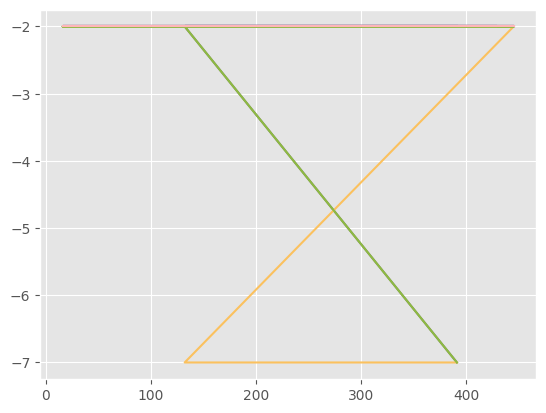

In [39]:
all_higher_than_treshold_patterns.sample(5, axis=0).plot(legend=None)
# plt.legend(False)

In [40]:
def get_increasing_patterns(df, min_start, max_end, gap_days_index: int = 3):
    
# VERSION 1
#     row_increasing_patterns = []
#     for idx, row in pathes_df.iterrows():
#         if min_start < max_end:

#             row_increasing = row[(row >= min_start) & (row <= max_end)].tolist()
#         else:
#             row_increasing = row[(row <= min_start) & (row >= max_end)].tolist()

#         if row_increasing and max_end in row_increasing:
            
#             slope = (row_increasing[-1] - row_increasing[0]) / len(row_increasing)
                
#             if min_start < max_end and slope > 0:
#                 row_increasing_patterns.append(row_increasing)
#             elif min_start > max_end and slope < 0:
#                 row_increasing_patterns.append(row_increasing)
#     row_increasing_patterns = pd.DataFrame(row_increasing_patterns)

#     row_increasing_patterns = []
#     for idx, row in df.iterrows():
#         if min_start < max_end:
#             row_increasing = row[(row >= min_start) & (row <= max_end)]
#         else:
#             row_increasing = row[(row <= min_start) & (row >= max_end)]


# VERSION 2
#         if (not row_increasing.empty) and (max_end in row_increasing.values):
#             index = pd.Series(row_increasing.index)
#             start_indices = index[index > (index.shift(1) + gap_days_index)].values
#             index_of_start_indices = index[index > (index.shift(1) + gap_days_index)].index.values
#             for idx, start_index in enumerate(start_indices):
#                 if idx == len(start_indices) -1:
#                     part_row = row_increasing[index_of_start_indices[idx]:]
#                 else:
#                     part_row = row_increasing[index_of_start_indices[idx]: index_of_start_indices[idx+1]]
#                 if max_end in part_row.values:
#                     row_increasing_patterns.append(part_row)
#     row_increasing_patterns = pd.DataFrame(row_increasing_patterns)


    # VERSION 3
    row_increasing_patterns = []
    for idx, row in df.iterrows():
    
        # FILTER OUT ROWS WITHOUT NEEDED VALUES
        if min_start < max_end:

            row = row[(row >= min_start) & (row <= max_end)]
        else:
            row = row[(row <= min_start) & (row >= max_end)]


        if (not row.empty) and (max_end in row.values):

            # DISJOIN ROWS BY TIME
            index = pd.Series(row.index)
            start_indices = index[index > (index.shift(1) + gap_days_index)].values
            index_of_start_indices = index[index > (index.shift(1) + gap_days_index)].index.values

            for idx, start_index in enumerate(start_indices):
                if idx == len(start_indices) -1:
                    part_row = row[index_of_start_indices[idx]:]
                else:
                    part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]]

                # FILTER OUT ONLY INCREASING PATERNS
                if max_end in part_row.values and len(part_row) > 1:
                    prev_harmonic = None
                    start_index = 0
                    part_row = part_row.values
                    min_harmonic = part_row[0]

                    for idx, harmonic_level in enumerate(part_row):
                        if harmonic_level == max_end and prev_harmonic != max_end:
                            increasing_harmonic = row[start_index: idx+1]
                            if len(increasing_harmonic) > 1 and part_row[start_index] == min_start:
                                row_increasing_patterns.append(increasing_harmonic)
                            start_index = idx+1
                            if start_index < len(part_row)-1:
                                min_harmonic = part_row[start_index]

                        # find the smallest harmonic start
                        if min_start < max_end:
                            if harmonic_level < min_harmonic:
                                min_harmonic = harmonic_level
                                start_index = idx + 1
                        else:
                            if harmonic_level > min_harmonic:
                                min_harmonic = harmonic_level
                                start_index = idx + 1
                        prev_harmonic = harmonic_level
    row_increasing_patterns = pd.DataFrame(row_increasing_patterns)
    return row_increasing_patterns

In [41]:
def get_percent_increasing(df, min_start, max_end):
    row_increasing_patterns = get_increasing_patterns(df, min_start, max_end)
    
    # VERSION 1
#     all_higher_than_treshold_patterns = []
#     for idx, row in pathes_df.iterrows():
#         if min_start < max_end:
#             row_higher = row[(row >= min_start)].tolist()
#         else:
#             row_higher = row[(row <= min_start)].tolist()

#         if row_higher:
#             all_higher_than_treshold_patterns.append(row_higher)
#     all_higher_than_treshold_patterns = pd.DataFrame(all_higher_than_treshold_patterns)


    # VERSION 2
    all_higher_than_treshold_patterns = []
    for idx, row in df.iterrows():
        if min_start < max_end:
            row = row[(row >= min_start)]#.tolist()
        else:
            row = row[(row <= min_start)]#.tolist()

        if not row.empty:
            index = pd.Series(row.index)
            start_indices = index[index > (index.shift(1) + gap_days_index)].values
            index_of_start_indices = index[index > (index.shift(1) + gap_days_index)].index.values

            for idx, start_index in enumerate(start_indices):
                if idx == len(start_indices) -1:
                    part_row = row[index_of_start_indices[idx]:].values
                else:
                    part_row = row[index_of_start_indices[idx]: index_of_start_indices[idx+1]].values

                prev_harmonic = None
                start_index = 0
                min_harmonic = part_row[0]
                len_row = len(part_row)

                for idx, harmonic_level in enumerate(part_row):
                    if (harmonic_level == min_start and prev_harmonic != min_start) or idx == len_row-1:
                        harmonics_oscilating = part_row[start_index: idx+1]

                        if len(harmonics_oscilating) > 1 and part_row[start_index] == min_start:
                            all_higher_than_treshold_patterns.append(harmonics_oscilating)
                        start_index = idx+1
                    prev_harmonic = harmonic_level
    all_higher_than_treshold_patterns = pd.DataFrame(all_higher_than_treshold_patterns)
    
    probability_pattern = row_increasing_patterns.shape[0] / all_higher_than_treshold_patterns.shape[0]
    return probability_pattern

In [42]:
def first_high_value(x):
    x = x.dropna()
    if x.empty:
        return None
    return x.index[0]

# SEARCH FOR different weeks

In [43]:
start2end_df_global = pd.DataFrame()
for week, path2count_dict in week2path2count.items():
    path2count = pd.Series(path2count_dict)
    path2count = path2count.copy()
    
    pathes_df = (
        path2count.apply(pd.Series)
            .replace('', np.nan)
            .dropna(how='all', axis=1)
            .astype(float)
            .dropna(axis=0)
    )
    
    start2end_pob = {}
    start2end_len = {}
    start2end_len_std = {}
    start2end_counts = {}

    MAX_END = 6
    for min_start in range(1, 5):
        row_increasing_patterns = get_increasing_patterns(pathes_df, min_start, MAX_END)
        len_till_end = row_increasing_patterns[row_increasing_patterns >= MAX_END-1].apply(first_high_value, 
                                                                                           axis=1)
        len_till_end_mean = len_till_end.mean()
        len_till_end_std = len_till_end.std()
        probability_pattern = get_percent_increasing(pathes_df, min_start, MAX_END)
        start2end_pob[min_start] = probability_pattern
        start2end_len[min_start] = len_till_end_mean
        start2end_len_std[min_start] = len_till_end_std
        start2end_counts[min_start] = row_increasing_patterns.shape[0]

    start2end_pob = pd.Series(start2end_pob)
    start2end_len = pd.Series(start2end_len)
    start2end_len_std = pd.Series(start2end_len_std).round(2)
    start2end_counts = pd.Series(start2end_counts)
    
    # create 
    start2end_df_start = pd.DataFrame.from_dict({'prob': start2end_pob, 
                                           'len_hours': start2end_len, 
                                           'count': start2end_counts,
                                           'len_hours_std': start2end_len_std})
    start2end_df_start['len_days'] = (start2end_df_start['len_hours'] / 24).round(2)
    start2end_df_start['end_harmonic'] = MAX_END


    start2end_pob = {}
    start2end_len = {}
    start2end_len_std = {}
    start2end_counts = {}
    MAX_END = -6
    for min_start in range(-1, -5, -1):
        row_increasing_patterns = get_increasing_patterns(pathes_df, min_start, MAX_END)

        len_till_end = row_increasing_patterns[row_increasing_patterns <= MAX_END+1].apply(
            first_high_value, axis=1)
        len_till_end_mean = len_till_end.mean()
        len_till_end_std = len_till_end.std()
        probability_pattern = get_percent_increasing(pathes_df, min_start, MAX_END)
        start2end_pob[min_start] = probability_pattern
        start2end_len[min_start] = len_till_end_mean
        start2end_len_std[min_start] = len_till_end_std
        start2end_counts[min_start] = row_increasing_patterns.shape[0]

#     start2end_pob = pd.Series(start2end_pob)
#     start2end_len = pd.Series(start2end_len)
#     start2end_len_std = pd.Series(start2end_len_std).round(2)
#     start2end_counts = pd.Series(start2end_counts)

    start2end_df_neg = pd.DataFrame.from_dict({'prob': start2end_pob, 
                                           'len_hours': start2end_len, 
                                           'count': start2end_counts,
                                           'len_hours_std': start2end_len_std})
    start2end_df_neg['len_days'] = (start2end_df_neg['len_hours'] / 24).round(2)
    start2end_df_neg['end_harmonic'] = MAX_END
    start2end_df = pd.concat([start2end_df_start, start2end_df_neg], axis=0)
    
#     print
#     start2end_df.index.name = 'start_harmonic'
    start2end_df = start2end_df.reset_index()
    
    start2end_df = start2end_df.rename(columns={'index': 'start_harmonic'})
    start2end_df['week_diapazon'] = week
    
    start2end_df_global = pd.concat([start2end_df_global, start2end_df], axis=0)
start2end_df_global = start2end_df_global.reset_index(drop=True)
start2end_df_global

,start_harmonic,prob,len_hours,count,len_hours_std,len_days,end_harmonic,week_diapazon
0,1,0.028513,243.000000,14,NaN,10.12,6,2
1,2,0.093294,123.600000,32,92.920000,5.15,6,2
2,3,0.225664,246.181818,51,104.890000,10.26,6,2
3,4,0.206107,267.769231,27,145.920000,11.16,6,2
4,-1,0.033827,49.571429,16,10.357882,2.07,-6,2
5,-2,0.056497,114.000000,30,46.346521,4.75,-6,2
6,-3,0.046296,54.000000,15,0.000000,2.25,-6,2
7,-4,0.026455,83.000000,5,82.663978,3.46,-6,2
8,1,0.062500,58.400000,23,34.150000,2.43,6,3
9,2,0.086957,82.500000,28,60.750000,3.44,6,3


In [44]:
start2end_df_global[start2end_df_global['start_harmonic'] == -4]

,start_harmonic,prob,len_hours,count,len_hours_std,len_days,end_harmonic,week_diapazon
7,-4,0.026455,83.000000,5,82.663978,3.46,-6,2
15,-4,0.070755,148.666667,15,186.615469,6.19,-6,3
23,-4,0.018116,10.333333,5,16.196707,0.43,-6,4
31,-4,0.031915,50.250000,6,93.862932,2.09,-6,1
39,-4,0.052632,14.500000,3,20.506097,0.60,-6,5


In [45]:
start_harmonic_prob_df = pd.pivot_table(start2end_df_global, index='start_harmonic', columns='week_diapazon',
               values='prob', aggfunc='last')
start_harmonic_prob_df.style.pipe(make_pretty, 0, 0.3)

week_diapazon,1,2,3,4,5
start_harmonic,,,,,
-4,0.032,0.026,0.071,0.018,0.053
-3,0.028,0.046,0.010,0.021,0.060
-2,0.029,0.056,0.031,0.067,0.100
-1,0.057,0.034,0.046,0.046,0.036
1,0.041,0.029,0.062,0.065,0.095
2,0.082,0.093,0.087,0.058,0.099
3,0.110,0.226,0.146,0.154,0.103
4,0.252,0.206,0.280,0.284,0.405


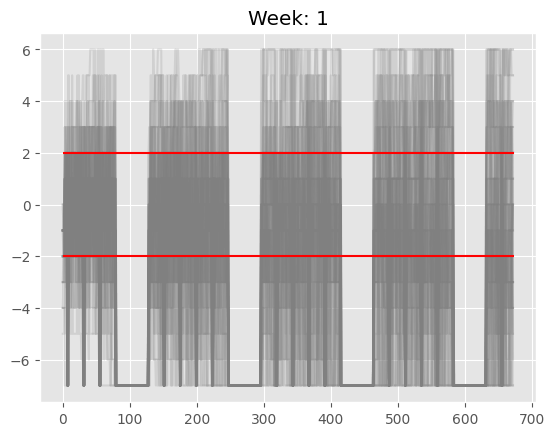

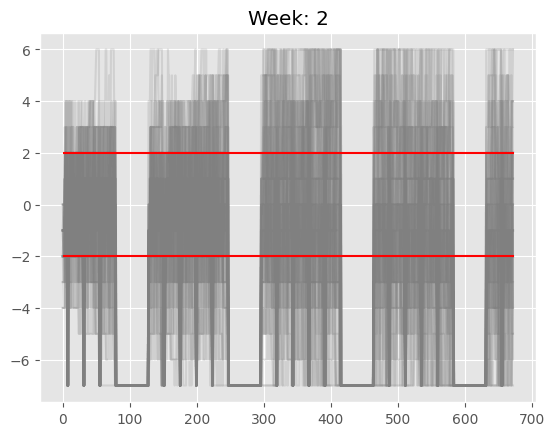

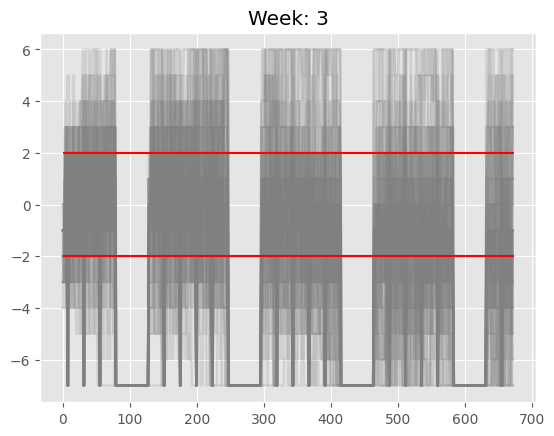

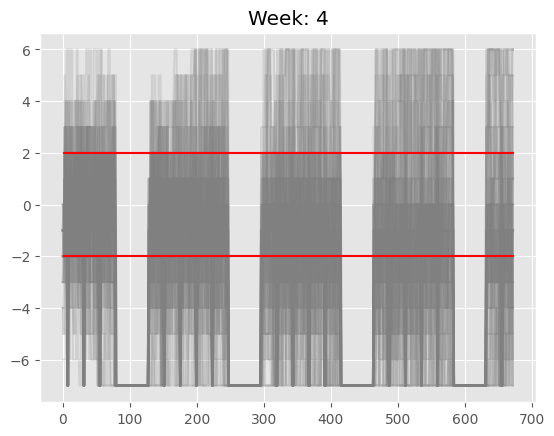

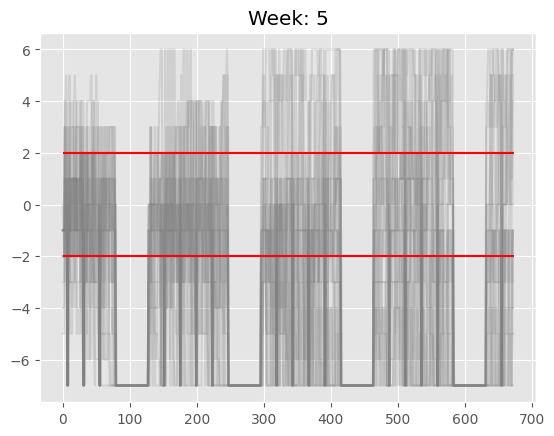

In [46]:
for week_number in range(1, 6):
    path2count_dict = week2path2count[week_number]
    path2count = pd.Series(path2count_dict).copy()
    path2count = path2count.copy()

    pathes_df = (
        path2count.apply(pd.Series)
            .replace('', np.nan)
            .dropna(how='all', axis=1)
            .astype(float)
            .dropna(axis=0)
    )
    plt.title(f'Week: {week_number}')
    for col in pathes_df.index:
        pathes_df.loc[col].plot(alpha=0.2, color='grey')
    plt.hlines(-2, 0, pathes_df.shape[1], color='red')
    plt.hlines(2, 0, pathes_df.shape[1], color='red')
    plt.show()

# For all weeks

In [47]:
start2end_pob = {}
start2end_len = {}
start2end_len_std = {}
start2end_counts = {}

MAX_END = 6
for min_start in range(1, 5):
    row_increasing_patterns = get_increasing_patterns(total_pathes_df, min_start, MAX_END)
    len_till_end = row_increasing_patterns[row_increasing_patterns >= MAX_END-1].apply(first_high_value, axis=1)
    len_till_end_mean = len_till_end.mean()
    len_till_end_std = len_till_end.std()
    probability_pattern = get_percent_increasing(total_pathes_df, min_start, MAX_END)
    start2end_pob[min_start] = probability_pattern
    start2end_len[min_start] = len_till_end_mean
    start2end_len_std[min_start] = len_till_end_std
    start2end_counts[min_start] = row_increasing_patterns.shape[0]

start2end_pob = pd.Series(start2end_pob)
start2end_len = pd.Series(start2end_len)
start2end_len_std = pd.Series(start2end_len_std).round(2)
start2end_counts = pd.Series(start2end_counts)

# create 
start2end_df_start = pd.DataFrame.from_dict({'prob': start2end_pob, 
                                       'len_hours': start2end_len, 
                                       'count': start2end_counts,
                                       'len_hours_std': start2end_len_std})
start2end_df_start['len_days'] = (start2end_df_start['len_hours'] / 24).round(2)
start2end_df_start['end_harmonic'] = MAX_END


start2end_pob = {}
start2end_len = {}
start2end_len_std = {}
start2end_counts = {}
MAX_END = -6
for min_start in range(-1, -5, -1):
    row_increasing_patterns = get_increasing_patterns(total_pathes_df, min_start, MAX_END)
    len_till_end = row_increasing_patterns[row_increasing_patterns <= MAX_END+1].apply(
        first_high_value, axis=1)
    len_till_end_mean = len_till_end.mean()
    len_till_end_std = len_till_end.std()
    probability_pattern = get_percent_increasing(total_pathes_df, min_start, MAX_END)
    start2end_pob[min_start] = probability_pattern
    start2end_len[min_start] = len_till_end_mean
    start2end_len_std[min_start] = len_till_end_std
    start2end_counts[min_start] = row_increasing_patterns.shape[0]

#     start2end_pob = pd.Series(start2end_pob)
#     start2end_len = pd.Series(start2end_len)
#     start2end_len_std = pd.Series(start2end_len_std).round(2)
#     start2end_counts = pd.Series(start2end_counts)

start2end_df_neg = pd.DataFrame.from_dict({'prob': start2end_pob, 
                                       'len_hours': start2end_len, 
                                       'count': start2end_counts,
                                       'len_hours_std': start2end_len_std})
start2end_df_neg['len_days'] = (start2end_df_neg['len_hours'] / 24).round(2)
start2end_df_neg['end_harmonic'] = MAX_END
start2end_df = pd.concat([start2end_df_start, start2end_df_neg], axis=0)

#     print
#     start2end_df.index.name = 'start_harmonic'
start2end_df = start2end_df.reset_index()

start2end_df = start2end_df.rename(columns={'index': 'start_harmonic'})
start2end_df

,start_harmonic,prob,len_hours,count,len_hours_std,len_days,end_harmonic
0,1,0.050612,80.130435,91,65.450000,3.34,6
1,2,0.082638,97.833333,109,95.630000,4.08,6
2,3,0.160102,187.113208,126,117.710000,7.80,6
3,4,0.264192,206.492537,121,150.820000,8.60,6
4,-1,0.045220,83.000000,105,61.526998,3.46,-6
5,-2,0.050573,106.272727,106,50.892221,4.43,-6
6,-3,0.028906,35.500000,42,23.501773,1.48,-6
7,-4,0.036876,64.937500,34,101.573926,2.71,-6


# Window size and predictability

In [48]:
X = pd.DataFrame(total_pathes_df.index.map(diapazon), index=total_pathes_df.index)
X

,0
2020-10,71.50
2020-11,114.75
2020-12,154.75
2020-13,219.75
2020-14,168.50
...,...
2023-50,36.75
2023-6,66.25
2023-7,70.50
2023-8,77.50


In [49]:
value_counts_df = pd.DataFrame()
for week_diapazon in total_pathes_df.index:
    value_counts = total_pathes_df.loc[week_diapazon].value_counts(normalize=True)
    value_counts_df = pd.concat([value_counts_df, value_counts], axis=1)
value_counts_df = value_counts_df.T.fillna(0)
value_counts_df

,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0
2020-10,0.313522,0.000000,0.000000,0.000000,0.000000,0.002972,0.026746,0.025260,0.034175,0.029718,0.034175,0.037147,0.049034,0.447251
2020-11,0.315007,0.000000,0.000000,0.000000,0.000000,0.000000,0.004458,0.023774,0.080238,0.170877,0.218425,0.132244,0.047548,0.007429
2020-12,0.349183,0.000000,0.000000,0.000000,0.037147,0.136701,0.196137,0.208024,0.065379,0.007429,0.000000,0.000000,0.000000,0.000000
2020-13,0.349183,0.000000,0.000000,0.000000,0.000000,0.245171,0.282318,0.123328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-14,0.349183,0.000000,0.000000,0.000000,0.000000,0.233284,0.265973,0.099554,0.052006,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-50,0.417533,0.109955,0.121842,0.044577,0.020802,0.005944,0.087667,0.104012,0.056464,0.031204,0.000000,0.000000,0.000000,0.000000
2023-6,0.320951,0.000000,0.000000,0.000000,0.000000,0.028232,0.087667,0.102526,0.200594,0.098068,0.090639,0.071322,0.000000,0.000000
2023-7,0.319465,0.000000,0.000000,0.000000,0.000000,0.000000,0.043091,0.075780,0.193165,0.138187,0.127786,0.083210,0.019316,0.000000
2023-8,0.313522,0.000000,0.000000,0.000000,0.000000,0.002972,0.157504,0.187221,0.105498,0.199108,0.034175,0.000000,0.000000,0.000000


### Pearson Corr

In [50]:
value_counts_df['diapazon_width'] = X
pearsonr = value_counts_df.corr()['diapazon_width'].drop('diapazon_width').sort_values()
pearsonr

-5.0   -0.434144
-4.0   -0.400589
-6.0   -0.379888
-7.0   -0.326953
6.0    -0.248515
-3.0   -0.227296
3.0    -0.156281
4.0    -0.153238
5.0    -0.138572
2.0     0.078326
-2.0    0.273184
1.0     0.395581
-1.0    0.501758
0.0     0.534132
Name: diapazon_width, dtype: float64

In [51]:
from scipy.stats import pearsonr
MAX_P_VALUE = 0.05
pearson_corr = pd.Series()
for col in value_counts_df.drop('diapazon_width', axis=1).columns:
    corr, p_value = pearsonr(value_counts_df[col], value_counts_df['diapazon_width'])
    if p_value <= MAX_P_VALUE:
        pearson_corr[col] = corr
pearson_corr.sort_values()

/tmp/ipykernel_5176/2892913279.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pearson_corr = pd.Series()


-5.0   -0.434144
-4.0   -0.400589
-6.0   -0.379888
-7.0   -0.326953
 6.0   -0.248515
-3.0   -0.227296
 3.0   -0.156281
 4.0   -0.153238
 5.0   -0.138572
-2.0    0.273184
 1.0    0.395581
-1.0    0.501758
 0.0    0.534132
dtype: float64

/tmp/ipykernel_5176/957352432.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  spearman_corr = pd.Series()


<Axes: >

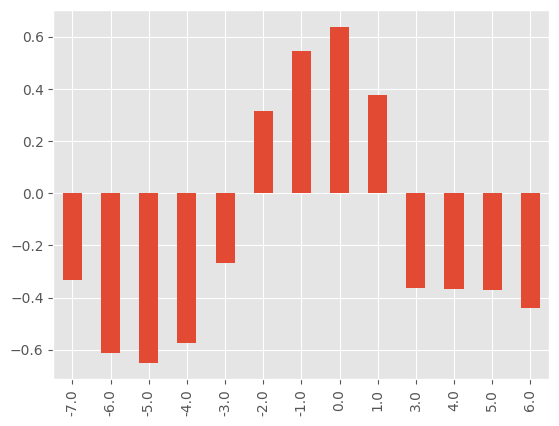

In [52]:
from scipy.stats import spearmanr
MAX_P_VALUE = 0.05
spearman_corr = pd.Series()
for col in value_counts_df.drop('diapazon_width', axis=1).columns:
    corr, p_value = spearmanr(value_counts_df[col], value_counts_df['diapazon_width'])
    if p_value <= MAX_P_VALUE:
        spearman_corr[col] = corr
spearman_corr.sort_index().plot(kind='bar')

In [53]:
harmonics

,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6
diapazan_week,,,,,,,,,,,,,
2020-10,3529.00,3457.50,3386.00,3314.50,3243.00,3171.50,3100.00,3028.50,2957.00,2885.50,2814.00,2742.50,2671.00
2020-11,3567.50,3452.75,3338.00,3223.25,3108.50,2993.75,2879.00,2764.25,2649.50,2534.75,2420.00,2305.25,2190.50
2020-12,3426.50,3271.75,3117.00,2962.25,2807.50,2652.75,2498.00,2343.25,2188.50,2033.75,1879.00,1724.25,1569.50
2020-13,3816.50,3596.75,3377.00,3157.25,2937.50,2717.75,2498.00,2278.25,2058.50,1838.75,1619.00,1399.25,1179.50
2020-14,3646.75,3478.25,3309.75,3141.25,2972.75,2804.25,2635.75,2467.25,2298.75,2130.25,1961.75,1793.25,1624.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-7,4609.50,4539.00,4468.50,4398.00,4327.50,4257.00,4186.50,4116.00,4045.50,3975.00,3904.50,3834.00,3763.50
2023-8,4538.00,4460.50,4383.00,4305.50,4228.00,4150.50,4073.00,3995.50,3918.00,3840.50,3763.00,3685.50,3608.00
2023-9,4245.25,4205.00,4164.75,4124.50,4084.25,4044.00,4003.75,3963.50,3923.25,3883.00,3842.75,3802.50,3762.25


# Find Resitances

In [111]:
diapazon

diapazan_week
2020-10     71.50
2020-11    114.75
2020-12    154.75
2020-13    219.75
2020-14    168.50
            ...  
2023-7      70.50
2023-8      77.50
2023-9      40.25
2024-1      62.50
2024-2      30.50
Length: 209, dtype: float64

In [130]:
diapazon_ser

diapazan_week
2020-10     71.50
2020-11    114.75
2020-12    154.75
2020-13    219.75
2020-14    168.50
            ...  
2023-7      70.50
2023-8      77.50
2023-9      40.25
2024-1      62.50
2024-2      30.50
Length: 209, dtype: float64

In [140]:
prices = es_df['close']
diapazon_week = '2020-7'
predefined_level = harmonics.loc[diapazon_week, 1]
harmonic_window = diapazon_ser[diapazon_week]
percentage_threshold = 0.25

shift_grey_zone = 3
WINDOW = 3

local_dip_condition = True
for window in range(1, WINDOW+1):    
    local_dip_condition = (
        local_dip_condition & (prices <= prices.shift(window)) & (prices <= prices.shift(-window))
    )
local_peak_condition = True
for window in range(1, WINDOW+1):    
    local_peak_condition = (
        local_peak_condition & (prices >= prices.shift(window)) & (prices >= prices.shift(-window))
    )
    
# check price levels
upper_bound = predefined_level + harmonic_window * percentage_threshold
lower_bound = predefined_level - harmonic_window * percentage_threshold
past_not_grey = (prices.shift(shift_grey_zone) >= upper_bound) | (prices.shift(shift_grey_zone) <= lower_bound)
future_not_grey = (prices.shift(-shift_grey_zone) >= upper_bound) | (prices.shift(-shift_grey_zone) <= lower_bound)
# future_not_grey = (prices.shift(-shift_grey_zone) <= lower_bound)
local_not_in_grey_zone_condition = past_not_grey | future_not_grey
# is price in grey zone
in_zone_condition = (prices <= upper_bound) & (prices >= lower_bound)
# get price values for support and resistance
condition_support = local_dip_condition & in_zone_condition & future_not_grey
condition_resistance = local_peak_condition & in_zone_condition & past_not_grey
resistance_levels = prices[condition_resistance]
support_levels = prices[condition_support]
print('Upper bound', upper_bound, 'lower bound', lower_bound)
print('# resistances', resistance_levels.shape[0], '# of supports:', support_levels.shape[0])
resistance_levels

Upper bound 3359.625 lower bound 3350.875
# resistances 7 # of supports: 10


time
2020-02-06 05:00:00+00:00    3353.50
2020-08-10 05:00:00+00:00    3354.75
2020-09-17 14:00:00+00:00    3351.50
2020-09-17 22:00:00+00:00    3355.25
2020-09-18 06:00:00+00:00    3352.50
2020-09-29 00:00:00+00:00    3357.00
2020-10-02 16:00:00+00:00    3354.00
Name: close, dtype: float64

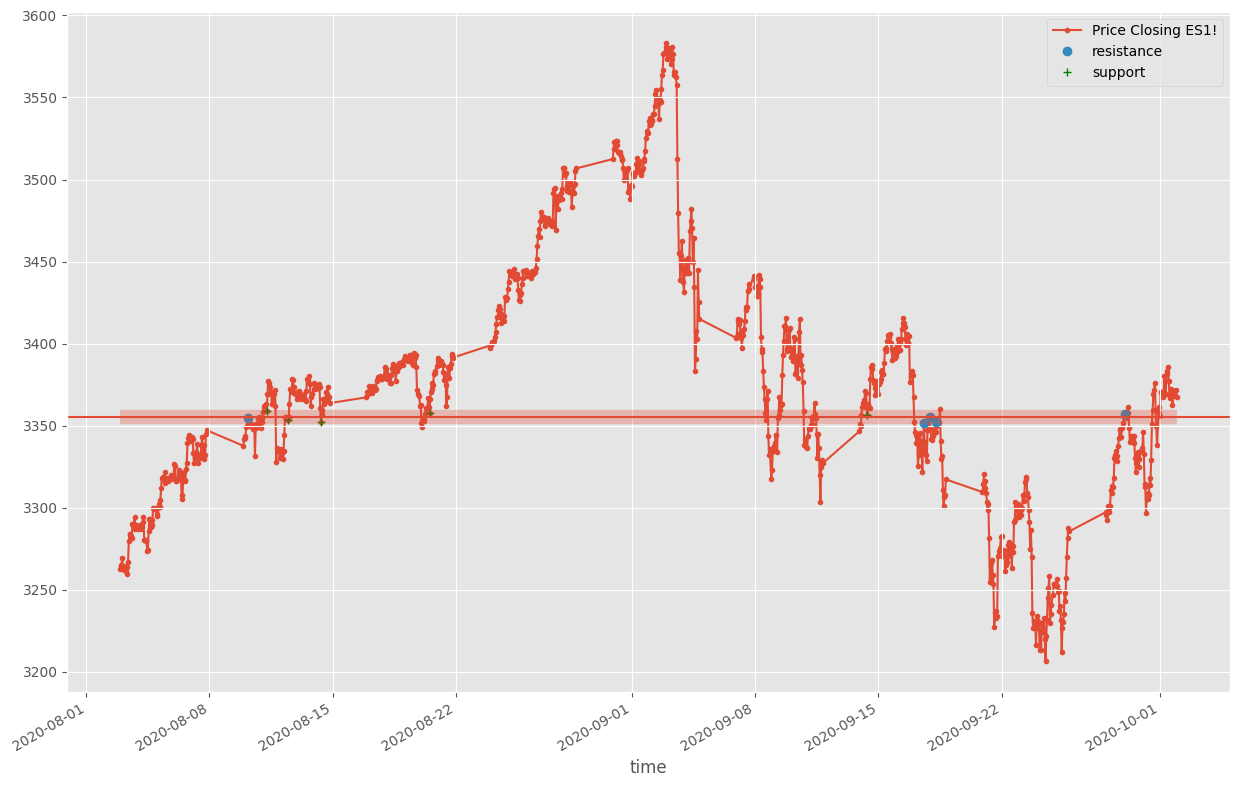

In [143]:
min_date = '2020-08-01'
max_date = '2020-10-01'
prices[min_date:max_date].plot(figsize=(15, 10), zorder=0, marker='o', markersize=3, label='Price Closing ES1!')
resistance_levels[min_date:max_date].plot(marker='o', linestyle='', zorder=1, label='resistance')
support_levels[min_date:max_date].plot(marker='+', linestyle='', zorder=1, color='green', label='support')
plt.fill_between(prices[min_date:max_date].index, 
                 upper_bound,
                 lower_bound, 
                 alpha=0.3)
plt.axhline(predefined_level)
plt.legend();

In [203]:
shift_grey_zone = 3
percentage_threshold = 2
WINDOW = 3
prices = es_df['close']
resistance_support_table = pd.DataFrame(index=es_df.index, columns=harmonics.index)
# es_df = es_df.assign(level_harmonic=None)

for diapazon_week in harmonics.index:
    for harmonic_level in harmonics.columns:
        harmonic_window = diapazon_ser[diapazon_week]
        predefined_level = harmonics.loc[diapazon_week, harmonic_level]
        local_dip_condition = True
        for window in range(1, WINDOW+1):    
            local_dip_condition = (
                local_dip_condition 
                & (prices <= prices.shift(window)) 
                & (prices <= prices.shift(-window))
            )

        local_peak_condition = True
        for window in range(1, WINDOW+1):    
            local_peak_condition = (
                local_peak_condition 
                & (prices >= prices.shift(window)) 
                & (prices >= prices.shift(-window))
            )

        # check price levels
        upper_bound = predefined_level + harmonic_window * percentage_threshold
        lower_bound = predefined_level - harmonic_window * percentage_threshold
        past_not_grey = (
            (prices.shift(shift_grey_zone) >= upper_bound) 
            | (prices.shift(shift_grey_zone) <= lower_bound)
        )
        future_not_grey = (
            (prices.shift(-shift_grey_zone) >= upper_bound) 
            | (prices.shift(-shift_grey_zone) <= lower_bound)
        )
        local_not_in_grey_zone_condition = past_not_grey | future_not_grey
        # is price in grey zone
        in_zone_condition = (prices <= upper_bound) & (prices >= lower_bound)
        # get price values for support and resistance
        condition_support = local_dip_condition & in_zone_condition & future_not_grey
        condition_resistance = local_peak_condition & in_zone_condition & past_not_grey
        
        resistance_support_table.loc[condition_resistance, f'{diapazon_week}'] = f'{harmonic_level}r'
        resistance_support_table.loc[condition_support, f'{diapazon_week}'] = f'{harmonic_level}s'
        
resistance_support_table

diapazan_week,2020-10,2020-11,2020-12,2020-13,2020-14,2020-15,2020-16,2020-17,2020-18,2020-19,...,2023-5,2023-50,2023-51,2023-52,2023-6,2023-7,2023-8,2023-9,2024-1,2024-2
time,,,,,,,,,,,,,,,,,,,,,
2020-01-14 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12 17:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-12 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-5r,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-12 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
resistance_support_table.loc[:, diapazon_week].dropna()

time
2021-10-27 13:00:00+00:00     6r
2021-10-28 14:00:00+00:00     6r
2021-11-02 16:00:00+00:00     4r
2021-11-03 01:00:00+00:00     4r
2021-11-03 09:00:00+00:00     4r
                            ... 
2024-01-11 16:00:00+00:00     2s
2024-01-11 19:00:00+00:00    -2r
2024-01-12 07:00:00+00:00     2s
2024-01-12 11:00:00+00:00     2s
2024-01-12 14:00:00+00:00    -2r
Name: 2024-2, Length: 127, dtype: object

[-3  3  2  1 -4  0 -5 -1 -6 -2]


/tmp/ipykernel_5176/2592221777.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Dark2')  # You can choose a different colormap


<Axes: title={'center': 'All resistance for 2021-1 harmonics'}, xlabel='time'>

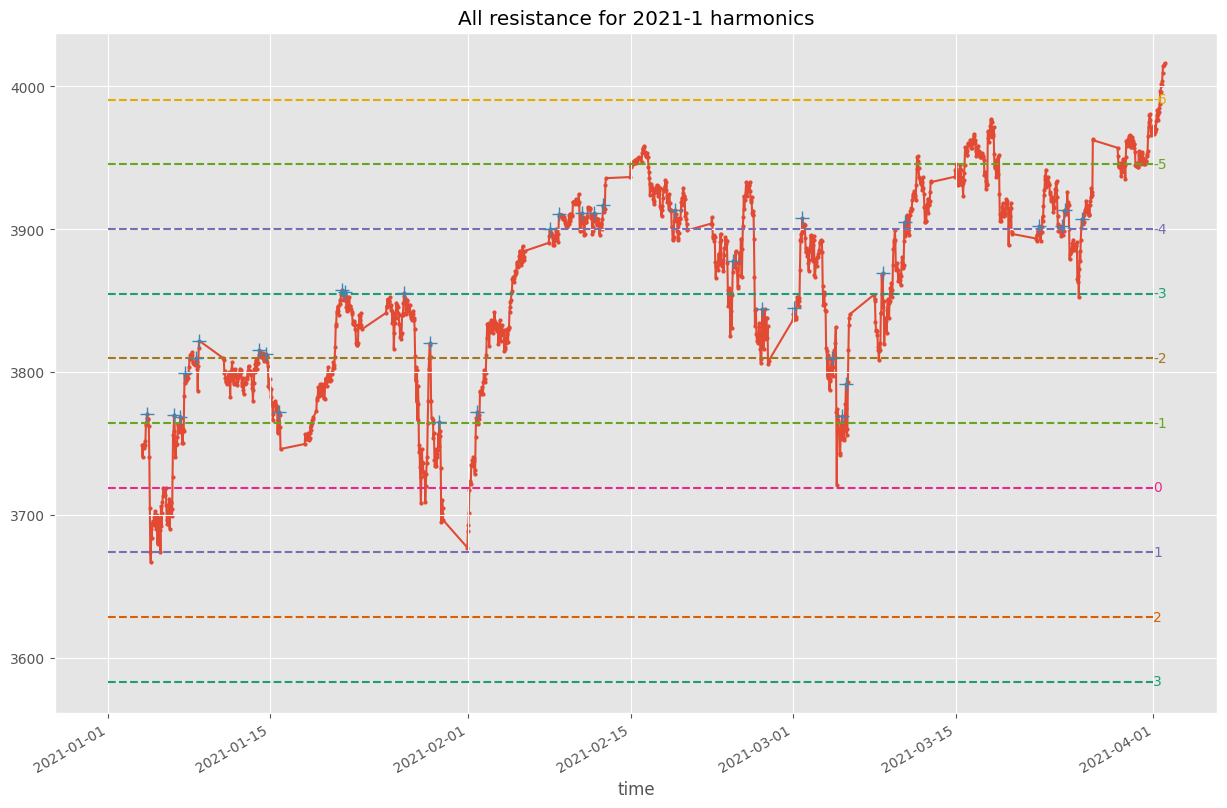

In [218]:
from matplotlib import cm

diapazon_week = '2021-1'
min_date = '2021-01-01'
max_date = '2021-04-01'
hormonic_res_sup_values = resistance_support_table.loc[:, diapazon_week].dropna()

unique_met_hormonics = hormonic_res_sup_values[min_date: max_date].str[:-1].astype(int).unique()
print(unique_met_hormonics)
is_resist = hormonic_res_sup_values[hormonic_res_sup_values.str[-1] == 'r'].str[:-1]
is_support = hormonic_res_sup_values[hormonic_res_sup_values.str[-1] == 's'].str[:-1]
plt.figure(figsize=(15, 10), )
prices.loc[min_date: max_date].plot(zorder=0, marker='o', 
                                    markersize=2,
                                    title=f'All resistance for {diapazon_week} harmonics')

    
colormap = cm.get_cmap('Dark2')  # You can choose a different colormap
# Generate a list of unique colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, harmonics.shape[1])]

for idx, level in enumerate(unique_met_hormonics):
    haromonics_levels_week = es_df['diapazan_week'].map({diapazon_week: harmonics.loc[diapazon_week, level]})
    harmonic_level_week = harmonics.loc[diapazon_week, level]
    plt.hlines(harmonic_level_week, min_date, max_date, color=colors[idx], linestyle='--')
    
    plt.text(max_date, harmonic_level_week, f'{level}', color=colors[idx],
             verticalalignment='center', horizontalalignment='left')
    
prices.loc[is_resist[min_date: max_date].index].plot(marker='+', linestyle='', markersize=10)

/tmp/ipykernel_5176/967974418.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Dark2')  # You can choose a different colormap


<Axes: title={'center': 'All support for 2021-1 harmonics'}, xlabel='time'>

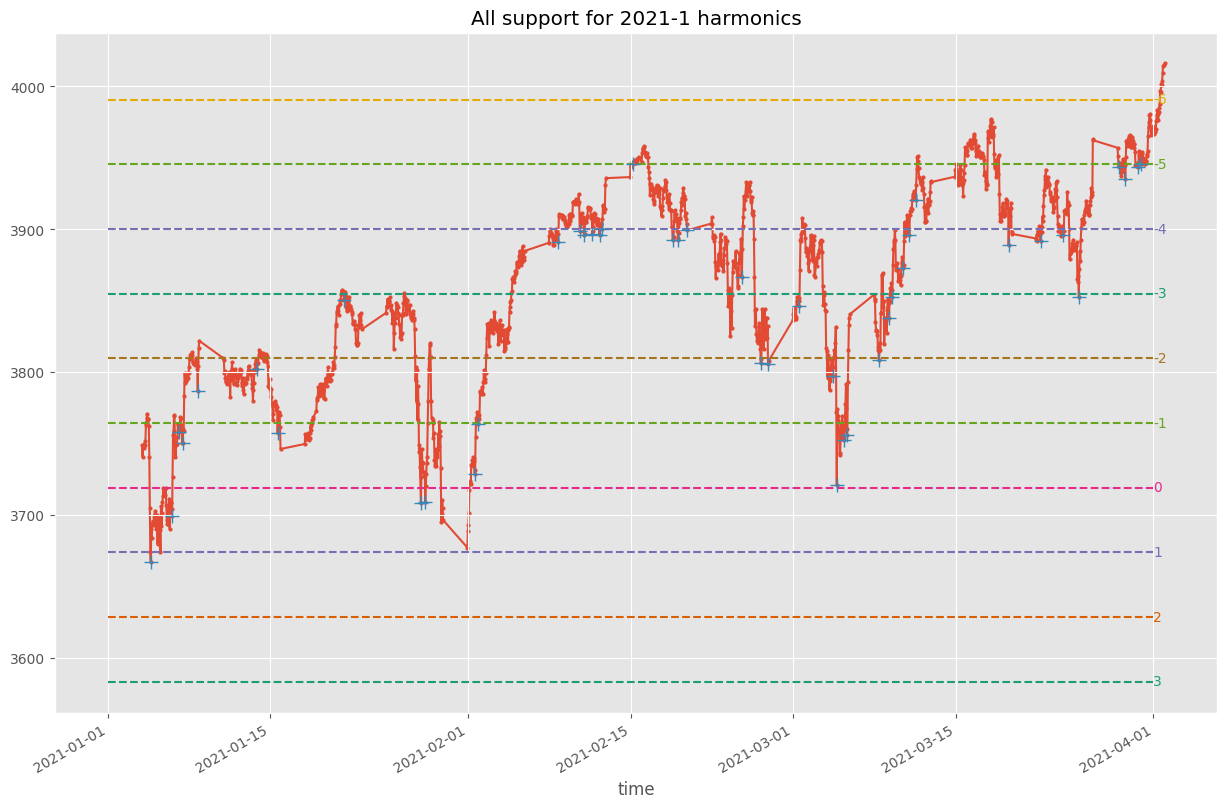

In [219]:
plt.figure(figsize=(15, 10), )
prices.loc[min_date: max_date].plot(zorder=0, marker='o', 
                                    markersize=2,
                                    title=f'All support for {diapazon_week} harmonics')

    
colormap = cm.get_cmap('Dark2')  # You can choose a different colormap
# Generate a list of unique colors from the colormap
colors = [colormap(i) for i in np.linspace(0, 1, harmonics.shape[1])]

for idx, level in enumerate(unique_met_hormonics):
    haromonics_levels_week = es_df['diapazan_week'].map({diapazon_week: harmonics.loc[diapazon_week, level]})
    harmonic_level_week = harmonics.loc[diapazon_week, level]
    plt.hlines(harmonic_level_week, min_date, max_date, color=colors[idx], linestyle='--')
    
    plt.text(max_date, harmonic_level_week, f'{level}', color=colors[idx],
             verticalalignment='center', horizontalalignment='left')
    
prices.loc[is_support[min_date: max_date].index].plot(marker='+', linestyle='', markersize=10)

In [223]:
is_support['2021-02-15']

time
2021-02-15 06:00:00+00:00    -3
Name: 2021-1, dtype: object

In [226]:
prices['2021-02-15']

time
2021-02-15 00:00:00+00:00    3943.75
2021-02-15 01:00:00+00:00    3944.00
2021-02-15 02:00:00+00:00    3944.75
2021-02-15 03:00:00+00:00    3947.00
2021-02-15 04:00:00+00:00    3946.25
2021-02-15 05:00:00+00:00    3946.25
2021-02-15 06:00:00+00:00    3945.50
2021-02-15 07:00:00+00:00    3946.00
2021-02-15 08:00:00+00:00    3948.00
2021-02-15 09:00:00+00:00    3947.75
2021-02-15 10:00:00+00:00    3948.75
2021-02-15 11:00:00+00:00    3947.25
2021-02-15 12:00:00+00:00    3946.00
2021-02-15 13:00:00+00:00    3947.50
2021-02-15 14:00:00+00:00    3949.00
2021-02-15 15:00:00+00:00    3949.75
2021-02-15 16:00:00+00:00    3950.00
2021-02-15 17:00:00+00:00    3950.50
2021-02-15 23:00:00+00:00    3947.00
Name: close, dtype: float64

In [228]:
prices['2021-02-15'] < prices['2021-02-15'].shift(1)

time
2021-02-15 00:00:00+00:00    False
2021-02-15 01:00:00+00:00    False
2021-02-15 02:00:00+00:00    False
2021-02-15 03:00:00+00:00    False
2021-02-15 04:00:00+00:00     True
2021-02-15 05:00:00+00:00    False
2021-02-15 06:00:00+00:00     True
2021-02-15 07:00:00+00:00    False
2021-02-15 08:00:00+00:00    False
2021-02-15 09:00:00+00:00     True
2021-02-15 10:00:00+00:00    False
2021-02-15 11:00:00+00:00     True
2021-02-15 12:00:00+00:00     True
2021-02-15 13:00:00+00:00    False
2021-02-15 14:00:00+00:00    False
2021-02-15 15:00:00+00:00    False
2021-02-15 16:00:00+00:00    False
2021-02-15 17:00:00+00:00    False
2021-02-15 23:00:00+00:00     True
Name: close, dtype: bool

In [229]:
prices['2021-02-15'].shift(1)

time
2021-02-15 00:00:00+00:00        NaN
2021-02-15 01:00:00+00:00    3943.75
2021-02-15 02:00:00+00:00    3944.00
2021-02-15 03:00:00+00:00    3944.75
2021-02-15 04:00:00+00:00    3947.00
2021-02-15 05:00:00+00:00    3946.25
2021-02-15 06:00:00+00:00    3946.25
2021-02-15 07:00:00+00:00    3945.50
2021-02-15 08:00:00+00:00    3946.00
2021-02-15 09:00:00+00:00    3948.00
2021-02-15 10:00:00+00:00    3947.75
2021-02-15 11:00:00+00:00    3948.75
2021-02-15 12:00:00+00:00    3947.25
2021-02-15 13:00:00+00:00    3946.00
2021-02-15 14:00:00+00:00    3947.50
2021-02-15 15:00:00+00:00    3949.00
2021-02-15 16:00:00+00:00    3949.75
2021-02-15 17:00:00+00:00    3950.00
2021-02-15 23:00:00+00:00    3950.50
Name: close, dtype: float64

In [165]:
total_pathes_df

,0,1,2,3,4,5,6,7,8,9,...,663,664,665,666,667,668,669,670,671,672
2020-10,-1.0,-1.0,-1.0,1.0,2.0,2.0,2.0,2.0,-7.0,2.0,...,6.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0
2020-11,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,-7.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
2020-12,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-7.0,0.0,0.0,...,-3.0,-3.0,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0
2020-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.0,-1.0,0.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-1.0,-1.0,-2.0,-1.0
2020-14,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-7.0,0.0,0.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-50,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0,-3.0,-7.0,-3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-6,-1.0,-1.0,-1.0,-2.0,-1.0,-1.0,-2.0,-2.0,-7.0,1.0,...,0.0,3.0,3.0,3.0,0.0,0.0,3.0,3.0,3.0,3.0
2023-7,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-7.0,1.0,...,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2023-8,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-7.0,-1.0,...,2.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


In [163]:
resistance_support_table.count()

diapazan_week
2020-10    197
2020-11    158
2020-12    102
2020-13    131
2020-14    132
          ... 
2023-7     563
2023-8     570
2023-9     566
2024-1     185
2024-2     127
Length: 209, dtype: int64

In [156]:
resistance_support_table

,diapazon_week
time,
2020-01-14 05:00:00+00:00,None
2020-01-14 06:00:00+00:00,None
2020-01-14 07:00:00+00:00,None
2020-01-14 08:00:00+00:00,None
2020-01-14 09:00:00+00:00,None
...,...
2024-01-12 17:00:00+00:00,None
2024-01-12 18:00:00+00:00,None
2024-01-12 19:00:00+00:00,None


In [154]:
condition_support

time
2020-01-14 05:00:00+00:00    False
2020-01-14 06:00:00+00:00    False
2020-01-14 07:00:00+00:00    False
2020-01-14 08:00:00+00:00    False
2020-01-14 09:00:00+00:00    False
                             ...  
2024-01-12 17:00:00+00:00    False
2024-01-12 18:00:00+00:00    False
2024-01-12 19:00:00+00:00    False
2024-01-12 20:00:00+00:00    False
2024-01-12 21:00:00+00:00    False
Name: close, Length: 23663, dtype: bool

In [151]:
resistance_support_table

,level_harmonic_2020-10,level_harmonic_2020-11,level_harmonic_2020-12,level_harmonic_2020-13,level_harmonic_2020-14,level_harmonic_2020-15,level_harmonic_2020-16,level_harmonic_2020-17,level_harmonic_2020-18,level_harmonic_2020-19,...,level_harmonic_2023-5,level_harmonic_2023-50,level_harmonic_2023-51,level_harmonic_2023-52,level_harmonic_2023-6,level_harmonic_2023-7,level_harmonic_2023-8,level_harmonic_2023-9,level_harmonic_2024-1,level_harmonic_2024-2
time,,,,,,,,,,,,,,,,,,,,,
2020-01-14 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-14 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-12 17:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-12 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6r,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-12 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
print(resistance_support_table['level_harmonic'].count(), resistance_support_table['level_harmonic'].shape)

(4715, (23663,))

In [ ]:
z = x[:interested_index[0]]
print(z.shape)
cond1 = z >= z.shift(1)
z = z[cond1]
length = z.index[-1] - z.index[0]
length

In [ ]:
a = pd.Series(z.index)
a.diff().describe()

In [152]:
query_value = 6.5
info_dict = defaultdict(list)
for idx, row in pathes_df.iterrows():
    x = row.rolling(6).mean()
    x = x.dropna()
    cond = (x >= query_value) & (x.shift(1) < query_value)
    interested_index = x[cond].index
    
    if not interested_index.empty:
        z = x[:interested_index[0]]

        cond1 = z >= z.shift(1)
        z = z[cond1]
        length = z.index[-1] - z.index[0]

        info_dict[z.iloc[0]].append({'length': length, 'streak': z.values})
info_ser = pd.Series(info_dict)
info_ser.apply(pd.Series)

,0,1,2,3
1.0,"{'length': 395, 'streak': [1.0, 1.0, 1.0, 1.0,...","{'length': 198, 'streak': [1.0, 1.0, 1.0, 1.0,...","{'length': 65, 'streak': [1.0, 1.0, 1.0, 1.0, ...","{'length': 508, 'streak': [1.0, 1.0, 1.0, 0.33..."
1.5,"{'length': 147, 'streak': [1.5, 1.666666666666...",NaN,NaN,NaN
0.5,"{'length': 137, 'streak': [0.5, 0.5, 0.5, 0.66...",NaN,NaN,NaN


In [144]:
z

6      1.000000
7      1.000000
8      1.000000
9      1.000000
10     1.000000
         ...   
306    2.833333
307    3.000000
308    3.000000
309    3.000000
311    2.833333
Name: 15, Length: 287, dtype: float64

In [76]:
pathes_df.cummax(axis=1)

,0,1,2,3,4,5,6,7,8,9,...,663,664,665,666,667,668,669,670,671,672
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [83]:
def find_consecutive_streaks(series_a, series_b):
    streaks = []
    current_streak = []
    start_index = None

    for i, (a, b) in enumerate(zip(series_a, series_b)):
        if a == b:
            if start_index is None:
                start_index = i
            current_streak.append(a)
        else:
            if start_index is not None:
                streaks.append((start_index, i - 1, current_streak))
                current_streak = []
                start_index = None

    # Check for the last streak
    if start_index is not None:
        streaks.append((start_index, i, current_streak))

    return streaks

# Find consecutive matching streaks
streak2freq = defaultdict(int)
for idx in range(pathes_df.shape[0]-1):
    consecutive_streaks = find_consecutive_streaks(pathes_df.iloc[idx],
                                                   pathes_df.iloc[idx+1])
    for start, end, streak in consecutive_streaks:
        streak = ''.join([str(int(x)) for x in streak])
        streak2freq[streak] += 1

# # Print the results
# for start, end, streak in consecutive_streaks:
#     print(f"Consecutive Streak ({start}-{end}): {streak}")
len(streak2freq)

151

In [84]:
streak2freq = pd.Series(streak2freq).sort_values(ascending=False)
streak2freq[streak2freq > 2]

1                           65
0                           39
11                          26
2                           24
-1                          20
111                         17
3                           15
1111                        14
22                          13
-1-1                        12
7                           10
1111111111                  10
1111111                      9
000                          9
00                           9
4                            8
0000                         8
11111111111111111            8
111111111111111111111111     7
111111111                    7
222                          7
11111                        6
-1-1-1-1-1-1                 6
-1-1-1-1                     5
1111111111111                5
00000                        5
-2                           5
11111111                     5
33                           4
1111111111111111             4
111111111111                 4
2222                         4
11111111

In [116]:
pathes_df.dropna()

,0,1,2,3,4,5,6,7,8,9,...,663,664,665,666,667,668,669,670,671,672
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-6.0,-5.0,-5.0,-5.0,-5.0,-6.0,-6.0,-6.0,-6.0,-6.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,3.0,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-4.0,-4.0,-4.0,-3.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-2.0


In [87]:
sorted_series

 6      -4.5
 5     191.4
 4     387.3
 3     583.2
 2     779.1
 1     975.0
 0    1170.9
-1    1366.8
-2    1562.7
-3    1758.6
-4    1954.5
-5    2150.4
-6    2346.3
Name: 2021-1, dtype: float64

In [78]:
sorted_series.sort_values

-6    2346.3
-5    2150.4
-4    1954.5
-3    1758.6
-2    1562.7
-1    1366.8
 0    1170.9
 1     975.0
 2     779.1
 3     583.2
 4     387.3
 5     191.4
 6      -4.5
Name: 2021-1, dtype: float64

In [70]:
sorted_series

-6    2346.3
-5    2150.4
-4    1954.5
-3    1758.6
-2    1562.7
-1    1366.8
 0    1170.9
 1     975.0
 2     779.1
 3     583.2
 4     387.3
 5     191.4
 6      -4.5
Name: 2021-1, dtype: float64

In [64]:
sorted_series.shape

(13,)

In [63]:
index

13

In [196]:
offset = 1
target_cols = offset2cols[offset]
for col in target_cols:
    eth_df['close'].isin(eth_df[])

SyntaxError: invalid syntax (2597016072.py, line 4)

# harmonic width

# days in harmonic

In [45]:
eth_df[col]

time
2021-01-04 00:00:00+00:00    2020-50
2021-01-04 01:00:00+00:00    2020-50
2021-01-04 02:00:00+00:00    2020-50
2021-01-04 03:00:00+00:00    2020-50
2021-01-04 04:00:00+00:00    2020-50
                              ...   
2024-01-14 19:00:00+00:00    2023-50
2024-01-14 20:00:00+00:00    2023-50
2024-01-14 21:00:00+00:00    2023-50
2024-01-14 22:00:00+00:00    2023-50
2024-01-14 23:00:00+00:00    2023-50
Name: offset_4, Length: 26539, dtype: object

# Task

In [ ]:
1. Target current harmonic
2. Window: 1 month / 4 weeks
2. Features: 
    
    previous harmonic for 1st/2n/3rd/4th diapazon
    days in previous harmonic
    1st 2nd 3rd 4th diapazon
    the number of the last diapazon
    diapazon width

#### bitcoin

In [60]:
url = f"""
https://www.alphavantage.co/query
?function=CRYPTO_INTRADAY
&symbol=BTC
&market=USD
&interval=60min
&apikey={PREMIUM_API_KEY}
""".replace('\n', '')
print(url)
r = requests.get(url)
data = r.json()
bitcoin_df = pd.DataFrame(data['Time Series Crypto (60min)']).T
bitcoin_df

https://www.alphavantage.co/query?function=CRYPTO_INTRADAY&symbol=BTC&market=USD&interval=60min&apikey=B3NUDPWV2FSGX37H


,1. open,2. high,3. low,4. close,5. volume
2024-01-14 10:00:00,43052.41000,43066.56000,42939.80000,42981.85000,204
2024-01-14 09:00:00,42996.26000,43079.00000,42818.34000,43052.41000,775
2024-01-14 08:00:00,43011.44000,43030.00000,42888.00000,42996.25000,569
2024-01-14 07:00:00,42999.00000,43060.00000,42891.12000,43011.44000,960
2024-01-14 06:00:00,42749.99000,42999.00000,42749.99000,42998.99000,864
...,...,...,...,...,...
2024-01-10 11:00:00,45532.01000,45659.42000,45000.00000,45515.89000,2363
2024-01-10 10:00:00,45661.43000,45731.10000,45532.00000,45532.00000,1101
2024-01-10 09:00:00,45329.94000,45700.00000,45321.99000,45661.42000,2388
2024-01-10 08:00:00,45757.98000,45861.10000,45320.53000,45329.94000,2517


#### eurusd

In [62]:
url = f"""
https://www.alphavantage.co/query
?function=FX_INTRADAY
&from_symbol=EUR
&to_symbol=USD
&outputsize=compact
&interval=60min
&apikey={PREMIUM_API_KEY}
""".replace('\n', '')
print(url)
r = requests.get(url)
data = r.json()
print(data.keys())
eur_df = pd.DataFrame(data['Time Series FX (60min)']).T
eur_df

https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol=EUR&to_symbol=USD&market=USD&outputsize=compact&interval=60min&apikey=B3NUDPWV2FSGX37H
dict_keys(['Meta Data', 'Time Series FX (60min)'])


,1. open,2. high,3. low,4. close
2024-01-12 21:00:00,1.09557,1.09564,1.09502,1.09512
2024-01-12 20:00:00,1.09593,1.09635,1.09534,1.09560
2024-01-12 19:00:00,1.09497,1.09596,1.09488,1.09595
2024-01-12 18:00:00,1.09583,1.09588,1.09469,1.09496
2024-01-12 17:00:00,1.09663,1.09738,1.09579,1.09583
...,...,...,...,...
2024-01-08 22:00:00,1.09544,1.09564,1.09477,1.09495
2024-01-08 21:00:00,1.09608,1.09611,1.09490,1.09547
2024-01-08 20:00:00,1.09554,1.09630,1.09527,1.09611
2024-01-08 19:00:00,1.09644,1.09658,1.09486,1.09553


### DXY

In [75]:
dxy = pd.read_csv('data/TVC_DXY, 60 (1).csv')
dxy['time'] = pd.to_datetime(dxy['time'])
dxy

,time,open,high,low,close
0,2020-01-01 00:00:00+00:00,96.500,96.500,96.500,96.500
1,2020-01-01 01:00:00+00:00,96.502,96.975,96.480,96.913
2,2020-01-01 02:00:00+00:00,97.005,97.101,97.005,97.061
3,2020-01-01 03:00:00+00:00,97.006,97.103,97.006,97.061
4,2020-01-01 04:00:00+00:00,97.061,97.103,97.006,97.093
...,...,...,...,...,...
25063,2024-01-12 17:00:00+00:00,102.389,102.486,102.385,102.455
25064,2024-01-12 18:00:00+00:00,102.460,102.470,102.376,102.380
25065,2024-01-12 19:00:00+00:00,102.381,102.420,102.338,102.404
25066,2024-01-12 20:00:00+00:00,102.407,102.447,102.397,102.442


In [49]:
df.index = pd.to_datetime(df.index)
df

,1. open,2. high,3. low,4. close,5. volume
2024-01-12 20:00:00,476.6800,476.6800,476.6800,476.6800,670811
2024-01-12 19:00:00,475.8000,475.8800,475.6200,475.6200,28328
2024-01-12 18:00:00,475.9800,476.6800,475.5500,475.7000,764975
2024-01-12 17:00:00,476.1200,476.3300,461.2820,476.0000,64551
2024-01-12 16:00:00,476.6600,477.1450,475.9700,476.1500,6408788
...,...,...,...,...,...
2023-12-22 08:00:00,472.7900,474.0000,471.8900,473.9700,762319
2023-12-22 07:00:00,472.7100,472.9500,472.6000,472.6600,88911
2023-12-22 06:00:00,472.6500,472.7700,472.4400,472.7300,134977
2023-12-22 05:00:00,472.4000,472.6500,472.2600,472.6400,31554


In [52]:
df.index = df.index.tz_localize('US/Eastern').tz_convert('UTC')
fg

DatetimeIndex(['2024-01-13 01:00:00+00:00', '2024-01-13 00:00:00+00:00',
               '2024-01-12 23:00:00+00:00', '2024-01-12 22:00:00+00:00',
               '2024-01-12 21:00:00+00:00', '2024-01-12 20:00:00+00:00',
               '2024-01-12 19:00:00+00:00', '2024-01-12 18:00:00+00:00',
               '2024-01-12 17:00:00+00:00', '2024-01-12 16:00:00+00:00',
               ...
               '2023-12-22 18:00:00+00:00', '2023-12-22 17:00:00+00:00',
               '2023-12-22 16:00:00+00:00', '2023-12-22 15:00:00+00:00',
               '2023-12-22 14:00:00+00:00', '2023-12-22 13:00:00+00:00',
               '2023-12-22 12:00:00+00:00', '2023-12-22 11:00:00+00:00',
               '2023-12-22 10:00:00+00:00', '2023-12-22 09:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=238, freq=None)

In [32]:
data['Meta Data']

{'1. Information': 'Intraday (60min) open, high, low, close prices and volume',
 '2. Symbol': 'ES',
 '3. Last Refreshed': '2024-01-12 19:00:00',
 '4. Interval': '60min',
 '5. Output Size': 'Full size',
 '6. Time Zone': 'US/Eastern'}

# ES1 and NS1 futures data

In [53]:
es1 = pd.read_csv('data/CME_MINI_DL_ES1!, 60 (1).csv')
es1

,time,open,high,low,close
0,2020-01-09T13:00:00Z,3268.50,3271.75,3267.25,3270.75
1,2020-01-09T14:00:00Z,3270.75,3274.00,3265.50,3269.25
2,2020-01-09T15:00:00Z,3269.00,3274.75,3266.00,3274.00
3,2020-01-09T16:00:00Z,3274.00,3275.25,3270.00,3274.25
4,2020-01-09T17:00:00Z,3274.50,3275.25,3264.25,3269.50
...,...,...,...,...,...
23719,2024-01-12T17:00:00Z,4807.00,4815.00,4803.50,4811.50
23720,2024-01-12T18:00:00Z,4811.50,4820.50,4811.50,4819.50
23721,2024-01-12T19:00:00Z,4819.75,4823.75,4811.50,4812.75
23722,2024-01-12T20:00:00Z,4812.75,4819.50,4807.75,4816.75


In [55]:
nq1 = pd.read_csv('data/CME_MINI_DL_NQ1!, 60 (1).csv')
nq1

,time,open,high,low,close
0,2020-01-12T23:00:00Z,8979.00,8999.50,8979.00,8987.50
1,2020-01-13T00:00:00Z,8987.75,8997.25,8985.25,8995.00
2,2020-01-13T01:00:00Z,8995.25,9013.25,8995.25,9001.25
3,2020-01-13T02:00:00Z,9001.25,9012.25,9000.00,9011.00
4,2020-01-13T03:00:00Z,9011.00,9014.75,9009.25,9010.50
...,...,...,...,...,...
23687,2024-01-12T17:00:00Z,16928.75,16965.00,16917.25,16953.75
23688,2024-01-12T18:00:00Z,16953.75,16983.25,16953.50,16979.25
23689,2024-01-12T19:00:00Z,16979.25,16994.00,16943.50,16951.00
23690,2024-01-12T20:00:00Z,16951.25,16980.00,16932.00,16972.25
